# PLots for Mid-Project presentation

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import pymc as pm
import numpy as np
from typing import Dict, Optional
from scipy.stats import skew, kurtosis


def bayesian_inference(
    X: np.ndarray,
    likelihood_model: str = 'Normal',
    df: Optional[float] = None,
    n_samples: int = 250,
    n_tune: int = 1000,
    random_seed: int = 42,
    n_generated: int = 1000
) -> Dict[str, np.ndarray]:
    """
    Perform Bayesian inference using uninformative priors.
    
    Parameters:
    -----------
    X : np.ndarray
        Observed data
    likelihood_model : str
        'Normal' or 'StudentT'
    df : float or None
        Degrees of freedom for Student-t distribution
    n_samples : int
        Number of posterior samples to draw
    n_tune : int
        Number of tuning steps for MCMC
    random_seed : int
        Random seed for reproducibility
    n_generated : int
        Number of samples to generate for derived statistics
    
    Returns:
    --------
    Dict[str, np.ndarray]
        Dictionary containing posterior samples for:
        - 'theta_mean': location parameter
        - 'theta_std': scale parameter
        - 'theta_median': median
        - 'theta_skewness': skewness
        - 'theta_kurtosis': kurtosis
    """
    
    # Validate inputs
    if likelihood_model not in ['Normal', 'StudentT']:
        raise ValueError("likelihood_model must be either 'Normal' or 'StudentT'")
    
    if likelihood_model == 'StudentT' and df is None:
        raise ValueError("df must be provided for Student-t likelihood")

    # Create the Bayesian model
    with pm.Model() as model:
        # Uninformative priors
        # Flat (uniform) prior for location parameter
        theta_mean = pm.Flat('theta_mean')
        
        # Jeffreys prior (1/σ) for scale parameter
        theta_std = pm.HalfFlat('theta_std')

        # Likelihood  # Note, even if the object likelihood is not used, this is still required by pymc
        if likelihood_model == 'Normal':
            likelihood = pm.Normal('likelihood',
                                mu=theta_mean,
                                sigma=theta_std,
                                observed=X)
        else:  # student-t
            likelihood = pm.StudentT('likelihood',
                                nu=df,
                                mu=theta_mean,
                                sigma=theta_std*np.sqrt((df-2)/df),  # sigma is the scale parameter: std = sqrt(df/(df-2))*scale
                                observed=X)

        # Sampling
        trace = pm.sample(n_samples,
                        tune=n_tune,
                        random_seed=random_seed,
                        return_inferencedata=False)

    # Extract samples
    theta_samples = {
        'theta_mean': trace.get_values('theta_mean'),
        'theta_std': trace.get_values('theta_std')
    }
    
    # Compute derived statistics
    np.random.seed(random_seed)
    n_posterior = len(theta_samples['theta_mean'])
    medians = np.zeros(n_posterior)
    skewness = np.zeros(n_posterior)
    kurt = np.zeros(n_posterior)
    
    for i in range(n_posterior):
        if likelihood_model == 'normal':
            samples = np.random.normal(
                loc=theta_samples['theta_mean'][i],
                scale=theta_samples['theta_std'][i],
                size=n_generated
            )
        else:
            with pm.Model():
                y_studentt = pm.StudentT(
                    "y_studentt",
                    nu=df,
                    mu=theta_samples['theta_mean'][i],
                    sigma=theta_samples['theta_std'][i]*np.sqrt((df-2)/df),  # scale parameter
                    size=n_generated
                )
                samples = pm.draw(y_studentt)
        
        medians[i] = np.median(samples)
        skewness[i] = skew(samples)
        kurt[i] = kurtosis(samples, fisher=True)
    
    theta_samples.update({
        'theta_median': medians,
        'theta_skewness': skewness,
        'theta_kurtosis': kurt,
    })
    
    return theta_samples

In [4]:
# ======================
# Configuration Section
# ======================
SEED = None
NORMAL_LOC, NORMAL_SCALE = 0, 2  # Scale is standard deviation
T_DF = 5
SKEW_ALPHA, SKEW_LOC, SKEW_SCALE = 5, 0, 1
class Config:
    # Experiment parameters
    SEED = SEED
    N_OBS = 200
    B = 250
    N_RESAMPLE = 2000
    NORMAL_LOC, NORMAL_SCALE = NORMAL_LOC, NORMAL_SCALE  # Scale is standard deviation
    T_DF = T_DF = 5
    SKEW_ALPHA, SKEW_LOC, SKEW_SCALE = SKEW_ALPHA, SKEW_LOC, SKEW_SCALE
    
    # Data generation parameters
    DATA_GENERATORS = {
        'Normal': {
            'generator': lambda size: stats.norm.rvs(loc=NORMAL_LOC, scale=NORMAL_SCALE, size=size),
            'population_size': 10**6
        },
        'SkewNormal': {
            'generator': lambda size: stats.skewnorm.rvs(a=SKEW_ALPHA, loc=0, scale=1, size=size),
            'population_size': 10**6
        },
        'StudentT': {
            'generator': lambda size: stats.t.rvs(df=T_DF, size=size),
            'population_size': 10**6
        },
        # 'StudentTMixture': {
        #     'generator': lambda size: np.choose(
        #         np.random.choice([0, 1, 2], size=size, p=[0.3, 0.1, 0.6]),
        #         [
        #             stats.t.rvs(df=T_DF, loc=-5, scale=1, size=size),
        #             stats.t.rvs(df=T_DF, loc=0, scale=1, size=size),
        #             stats.t.rvs(df=T_DF, loc=4, scale=1, size=size)
        #         ]
        #     ),
        #     'population_size': 10**8
        # },
    }
    
    # Parameters to estimate (add new parameters here)
    THETA_FUNCTIONS = {
        'mean': lambda x: np.mean(x),
        'median': lambda x: np.median(x),
        'std': lambda x: np.std(x),
        'skewness': lambda x: stats.skew(x),
        'kurtosis': lambda x: stats.kurtosis(x),
        'expected_shortfall_95': lambda x: np.mean(x[x < np.percentile(x, 5)]),
    }
    
    # Inference methods (add new methods here)
    INFERENCE_METHODS = {
        # 'freq_bootstrap': {
        #     'function': None,  # Will be filled later
        #     'requires_resample': False
        # },
        # 'bayesian_bootstrap': {
        #     'function': None,
        #     'requires_resample': False
        # },
        'garelli_normal': {
            'function': None,
            'requires_resample': True
        },
        'garelli_t': {
            'function': None,
            'requires_resample': True
        },
        'empirical': {
            'function': None,
            'requires_resample': True
        },
        # 'bayesian_uninformative': {  
        #     'function': None,
        #     'requires_resample': False
        # },
    }
    

# ======================
# Core Components
# ======================

class DataGenerator:
    def __init__(self, config):
        self.config = config
        np.random.seed(config.SEED)
        
        # Generate population data for all distributions
        self.populations = {}
        for dist_name, specs in config.DATA_GENERATORS.items():
            self.populations[dist_name] = {
                'data': specs['generator'](specs['population_size']),
                'true_theta': self._calculate_true_theta(specs['generator'](10**6))
            }
    
    def _calculate_true_theta(self, population):
        return {name: func(population) for name, func in Config.THETA_FUNCTIONS.items()}
    
    def get_observed_data(self, dist_name, n_obs):
        return self.populations[dist_name]['data'][:n_obs]

class InferenceEngine:
    def __init__(self, config):
        self.config = config
        self._register_methods()
        
    def _register_methods(self):
        """Register inference methods with their implementations"""
        methods = {
            # 'freq_bootstrap': self.freq_bootstrap,
            # 'bayesian_bootstrap': self.bayes_bootstrap,
            'garelli_normal': self.garelli_normal_predictive_resampling,
            'garelli_t': self.garelli_t_predictive_resampling,
            'empirical': self.empirical_predictive_resampling,
            # 'bayesian_uninformative': self.bayesian_inference_wrapper,
        }
        for name, func in methods.items():
            Config.INFERENCE_METHODS[name]['function'] = func
    
    # Method implementations (similar to original but parameterized)
    def freq_bootstrap(self, X, B, **kwargs):
        n = len(X)
        return [self._calculate_theta(np.random.choice(X, n, replace=True)) 
                for _ in range(B)]
    
    def bayes_bootstrap(self, X, B, **kwargs):
        thetas = []
        for _ in tqdm(range(B), desc="Bayes Boot"):
            weights = np.diff(np.concatenate(([0], np.sort(np.random.uniform(0,1,len(X)-1)), [1])))
            weighted_X = weights * X
            thetas.append(self._calculate_theta(weighted_X, weights=weights))
        return thetas
    
    def garelli_normal_predictive_resampling(self, X, B, n_resample, **kwargs):
        thetas = []
        X = list(X)
        for _ in tqdm(range(B), desc="Garelli Normal"):
            X_aug = X.copy()
            for _ in range(n_resample):
                pred_mean = np.mean(X_aug)
                pred_std = np.std(X_aug, ddof=1) if len(X_aug) > 1 else 1.0
                X_aug.append(np.random.normal(pred_mean, pred_std))
            thetas.append(self._calculate_theta(np.array(X_aug)))
        return thetas
    
    def garelli_t_predictive_resampling(self, X, B, n_resample, real_df=T_DF, **kwargs):
        thetas = []
        X = list(X)
        for _ in tqdm(range(B), desc="Garelli T"):
            X_aug = X.copy()
            for _ in range(n_resample):
                pred_mean = np.mean(X_aug)
                pred_std = np.std(X_aug) if len(X_aug) > 1 else 1.0
                pred_scale = pred_std*np.sqrt((real_df - 2) / real_df)
                X_aug.append(stats.t.rvs(loc=pred_mean, scale=pred_scale, df=real_df, size=1)[0])
            thetas.append(self._calculate_theta(np.array(X_aug)))
        return thetas

    def empirical_predictive_resampling(self, X, B, n_resample, **kwargs):
        """Implementation using inverse ECDF sampling"""
        from src.utils import ecdf_inv  # Import here or at top of file
        
        thetas = []
        X = list(X)  # Convert to mutable list
        
        for _ in tqdm(range(B), desc="Empirical Pred"):
            X_aug = X.copy()
            
            for _ in range(n_resample):
                u = np.random.uniform(0, 1)
                pred_sample = ecdf_inv(X_aug, u)
                X_aug.append(pred_sample)
            
            # Calculate all theta parameters for augmented sample
            theta = self._calculate_theta(np.array(X_aug))
            thetas.append(theta)
            
        return thetas
    
    def bayesian_inference_wrapper(self, X, B, **kwargs):
        """Wrapper for bayesian_inference to match the expected interface"""
        # Determine the likelihood model based on the distribution
        dist_name = kwargs.get('dist_name', 'Normal')
        
        # Set parameters for bayesian inference
        params = {
            'likelihood_model': dist_name,
            'n_samples': B,
            'df': T_DF #if dist_name == 'StudentT' else None
        }
        
        # Run bayesian inference
        theta_samples = bayesian_inference(X, **params)
        
        # Convert to list of dictionaries format expected by pipeline
        thetas = []
        for i in range(B):
            theta_dict = {
                'mean': theta_samples['theta_mean'][i],
                'median': theta_samples['theta_median'][i],
                'std': theta_samples['theta_std'][i],
                'skewness': theta_samples['theta_skewness'][i],
                'kurtosis': theta_samples['theta_kurtosis'][i],
                # 'expected_shortfall_95': theta_samples['theta_expected_shortfall_95'][i]
            }
            thetas.append(theta_dict)
            
        return thetas
        
    
    def _calculate_theta(self, x, weights=None):
        """Calculate all parameters for a sample"""
        if weights is not None:
            # Handle weighted calculations differently if needed
            return {name: func(x) for name, func in Config.THETA_FUNCTIONS.items()}
        return {name: func(x) for name, func in Config.THETA_FUNCTIONS.items()}

# ======================
# Results Handling
# ======================

class ResultStore:
    def __init__(self, config: Config = None):
        self.results = defaultdict(lambda: defaultdict(dict))
        self.config = config
    
    def add_result(self, dist_name, method_name, theta_name, estimates):
        self.results[dist_name][method_name][theta_name] = estimates
    
    def get_true_theta(self, data_gen, dist_name):
        return data_gen.populations[dist_name]['true_theta']

# ======================
# Experiment Runner
# ======================

def run_experiment(result_store = None):
    # Initialize components
    config = Config()
    data_gen = DataGenerator(config)
    inference_engine = InferenceEngine(config)
    if result_store is None:
        result_store = ResultStore(config)
    
    # Run experiments for each distribution
    for dist_name in config.DATA_GENERATORS:
        print(f"\nProcessing {dist_name}")
        X_obs = data_gen.get_observed_data(dist_name, config.N_OBS)
        
        # Run each inference method
        for method_name, specs in config.INFERENCE_METHODS.items():
            # Skip Bayesian inference for distributions other than Normal and StudentT
            if method_name == 'bayesian_uninformative' and dist_name not in ['Normal', 'StudentT']:
                continue
                
            print(f"  Method: {method_name}")
            
            # Get method parameters
            kwargs = {'dist_name': dist_name}  # Add distribution name to kwargs
            if specs['requires_resample']:
                kwargs['n_resample'] = config.N_RESAMPLE
                
            # Run inference
            estimates = specs['function'](X_obs, config.B, **kwargs)
            
            # Store results by parameter
            for theta_name in config.THETA_FUNCTIONS:
                theta_estimates = [e[theta_name] for e in estimates]
                result_store.add_result(dist_name, method_name, theta_name, theta_estimates)
        
        # Store true parameters
        result_store.results[dist_name]['true'] = data_gen.populations[dist_name]['true_theta']
    
    return result_store


    

In [5]:
# ======================
# Main Execution
# ======================

# if __name__ == "__main__":
results = run_experiment()
# config_nres5000 = Config()
# results_nres5000 = run_experiment()


Processing Normal
  Method: garelli_normal


Garelli Normal: 100%|██████████| 250/250 [01:18<00:00,  3.16it/s]


  Method: garelli_t


Garelli T: 100%|██████████| 250/250 [01:40<00:00,  2.49it/s]


  Method: empirical


Empirical Pred: 100%|██████████| 250/250 [01:15<00:00,  3.32it/s]



Processing SkewNormal
  Method: garelli_normal


Garelli Normal: 100%|██████████| 250/250 [01:18<00:00,  3.17it/s]


  Method: garelli_t


Garelli T: 100%|██████████| 250/250 [01:54<00:00,  2.18it/s]


  Method: empirical


Empirical Pred: 100%|██████████| 250/250 [01:15<00:00,  3.32it/s]



Processing StudentT
  Method: garelli_normal


Garelli Normal: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]


  Method: garelli_t


Garelli T: 100%|██████████| 250/250 [01:42<00:00,  2.43it/s]


  Method: empirical


Empirical Pred: 100%|██████████| 250/250 [01:19<00:00,  3.16it/s]


In [ ]:
# #save results
# import pickle
# with open('results_may04_new.pkl', 'wb') as f:
#     #convert defaultdict to regular dict for serialization
#     results_dict = {k: dict(v) for k, v in results.results.items()}
#     pickle.dump(results_dict, f)

In [ ]:
# PLotting
import matplotlib.pyplot as plt
from src.plotting import plot_posterior_distributions,

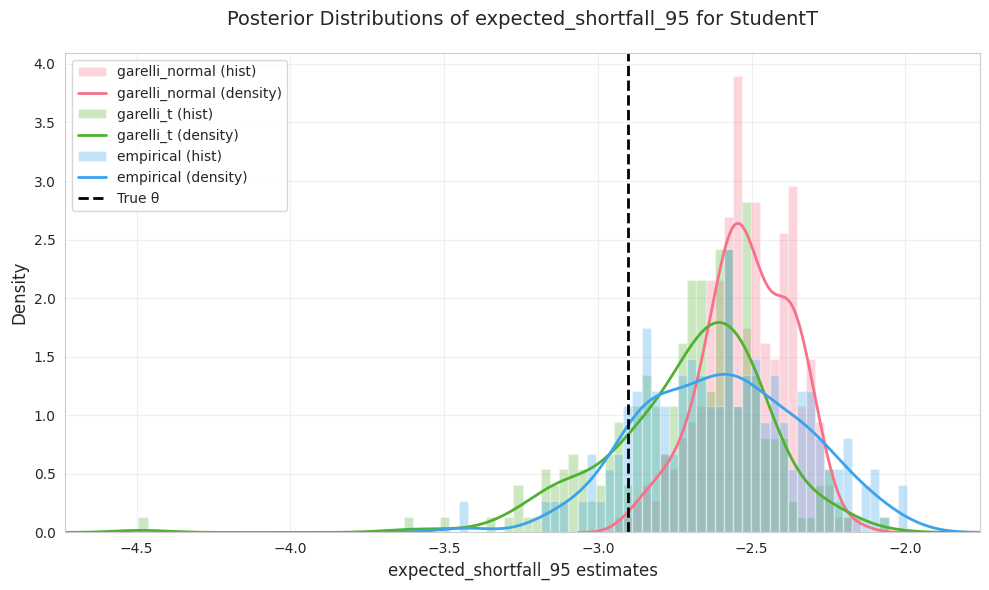

In [ ]:
# variance Normal
data_dist = 'StudentT'  # Choose from ['Normal', 'SkewNormal', 'StudentT', 'StudentTMixture']
param = 'expected_shortfall_95'  # Choose from ['mean', 'median', 'variance', 'skewness', 'kurtosis']
inference_methods = ['garelli_normal', 'garelli_t', 'empirical']
param_data_dict = {inference_method: thetas_samples[param] for inference_method, thetas_samples in results.results[data_dist].items() if inference_method in inference_methods}

true_theta = results.results[data_dist]['true'][param]

# true_theta = 0

plot_posterior_distributions(
    param_data_dict,
    true_theta=true_theta,
    plot_type='both',
    bins=100,
    figsize=(10, 6),
    title=f'Posterior Distributions of {param} for {data_dist}',
    xlabel=f'{param} estimates',
    ylabel='Density',
    show_legend=True,
    alpha=0.3,
    # x_range=(-1.5, 1.5),
)
plt.show()

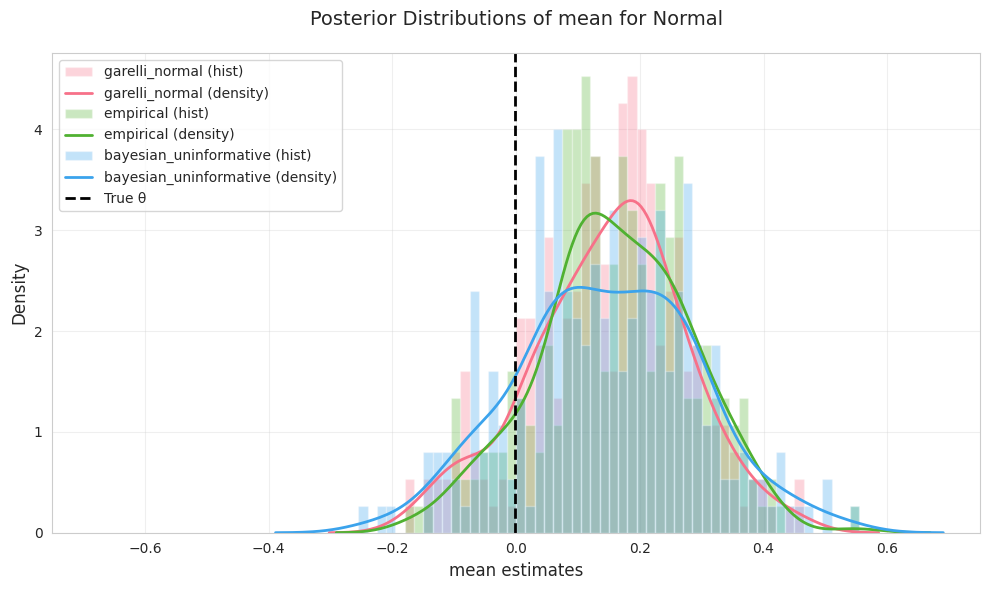

In [ ]:
# mean Normal
data_dist = 'Normal'  # Choose from ['Normal', 'SkewNormal', 'StudentT', 'StudentTMixture']
param = 'mean'  # Choose from ['mean', 'median', 'variance', 'skewness', 'kurtosis']
inference_methods = ['garelli_normal', 'empirical', 'bayesian_uninformative']  # ['garelli_normal', 'garelli_t', 'empirical', 'bayesian_uninformative']
param_data_dict = {inference_method: thetas_samples[param] for inference_method, thetas_samples in results.results[data_dist].items() if inference_method in inference_methods}

true_theta = results.results[data_dist]['true'][param]

plot_posterior_distributions(
    param_data_dict,
    true_theta=true_theta,
    plot_type='both',
    bins=100,
    figsize=(10, 6),
    title=f'Posterior Distributions of {param} for {data_dist}',
    xlabel=f'{param} estimates',
    ylabel='Density',
    show_legend=True,
    alpha=0.3,
    x_range=(-0.75, 0.75),
)
plt.show()

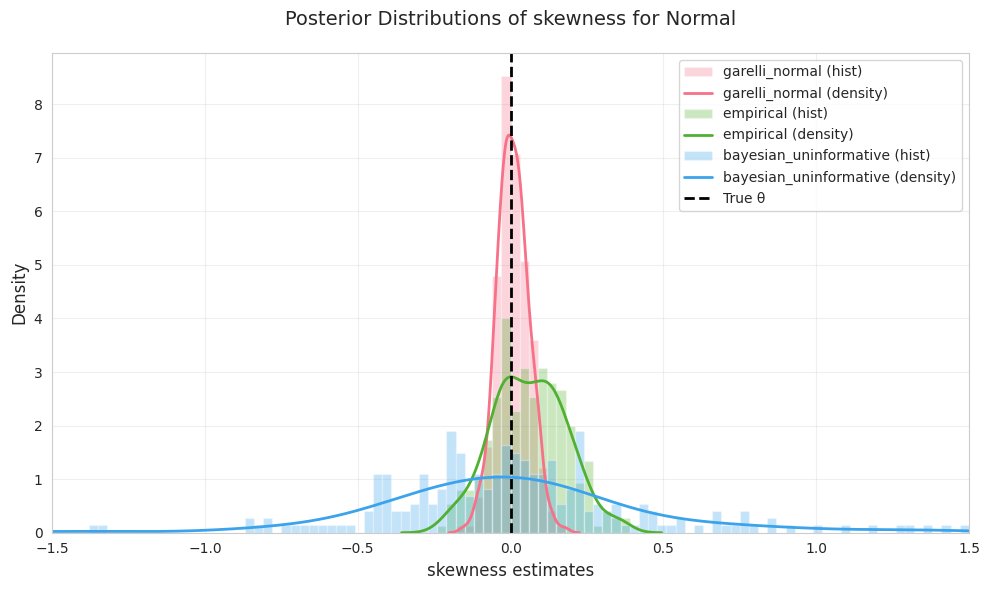

In [24]:
# variance Normal
data_dist = 'Normal'  # Choose from ['Normal', 'SkewNormal', 'StudentT', 'StudentTMixture']
param = 'skewness'  # Choose from ['mean', 'median', 'variance', 'skewness', 'kurtosis']
inference_methods = ['garelli_normal', 'empirical', 'bayesian_uninformative']  # ['garelli_normal', 'garelli_t', 'empirical', 'bayesian_uninformative']
param_data_dict = {inference_method: thetas_samples[param] for inference_method, thetas_samples in results.results[data_dist].items() if inference_method in inference_methods}

true_theta = results.results[data_dist]['true'][param]

plot_posterior_distributions(
    param_data_dict,
    true_theta=true_theta,
    plot_type='both',
    bins=100,
    figsize=(10, 6),
    title=f'Posterior Distributions of {param} for {data_dist}',
    xlabel=f'{param} estimates',
    ylabel='Density',
    show_legend=True,
    alpha=0.3,
    x_range=(-1.5,1.5),
)
plt.show()

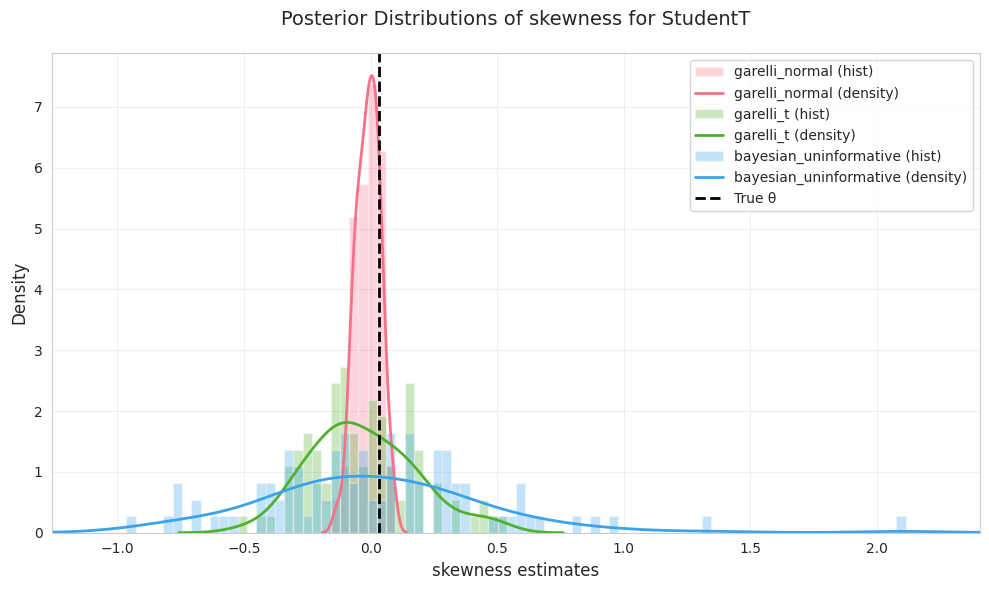

In [49]:
# variance Normal
data_dist = 'StudentT'  # Choose from ['Normal', 'SkewNormal', 'StudentT', 'StudentTMixture']
param = 'skewness'  # Choose from ['mean', 'median', 'variance', 'skewness', 'kurtosis']
inference_methods = ['garelli_normal', 'garelli_t', 'empirical', 'bayesian_uninformative']
param_data_dict = {inference_method: thetas_samples[param] for inference_method, thetas_samples in results.results[data_dist].items() if inference_method in inference_methods}

true_theta = results.results[data_dist]['true'][param]

plot_posterior_distributions(
    param_data_dict,
    true_theta=true_theta,
    plot_type='both',
    bins=100,
    figsize=(10, 6),
    title=f'Posterior Distributions of {param} for {data_dist}',
    xlabel=f'{param} estimates',
    ylabel='Density',
    show_legend=True,
    alpha=0.3,
    # x_range=(-1, 1),
)
plt.show()

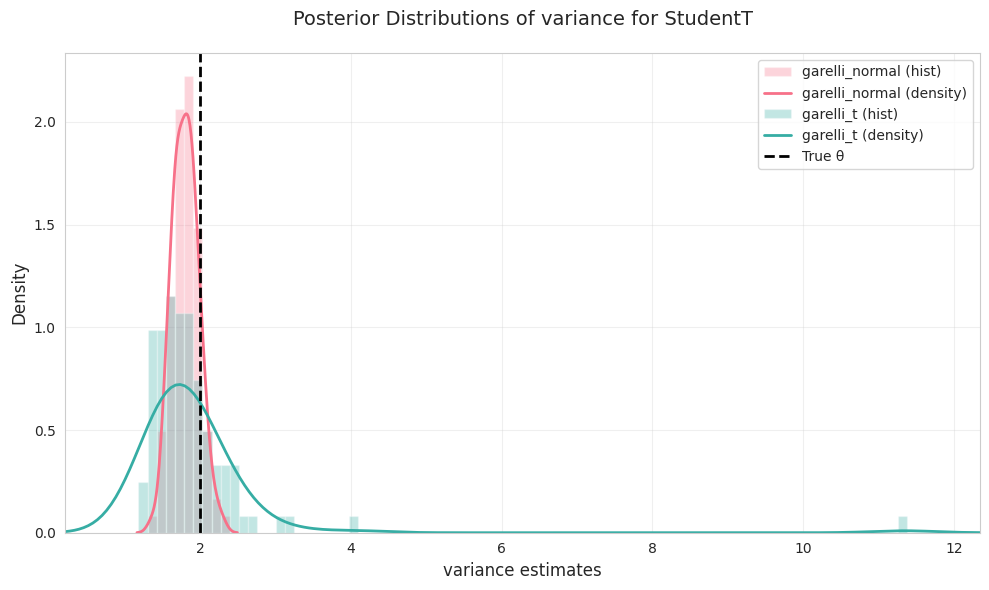

In [8]:
data_dist = 'StudentT'  # Choose from ['Normal', 'SkewNormal', 'StudentT', 'StudentTMixture']
param = 'variance'  # Choose from ['mean', 'median', 'variance', 'skewness', 'kurtosis']
inference_methods = ['garelli_normal', 'garelli_t', 'empirical', 'bayesian_uninformative']  # ['garelli_normal', 'garelli_t', 'empirical', 'bayesian_uninformative']
param_data_dict = {inference_method: thetas_samples[param] for inference_method, thetas_samples in results.results[data_dist].items() if inference_method in inference_methods}

true_theta = results.results[data_dist]['true'][param]

plot_posterior_distributions(
    param_data_dict,
    true_theta=true_theta,
    plot_type='both',
    bins=100,
    figsize=(10, 6),
    title=f'Posterior Distributions of {param} for {data_dist}',
    xlabel=f'{param} estimates',
    ylabel='Density',
    show_legend=True,
    alpha=0.3,
    # x_range=(-10, 10),
)
plt.show()

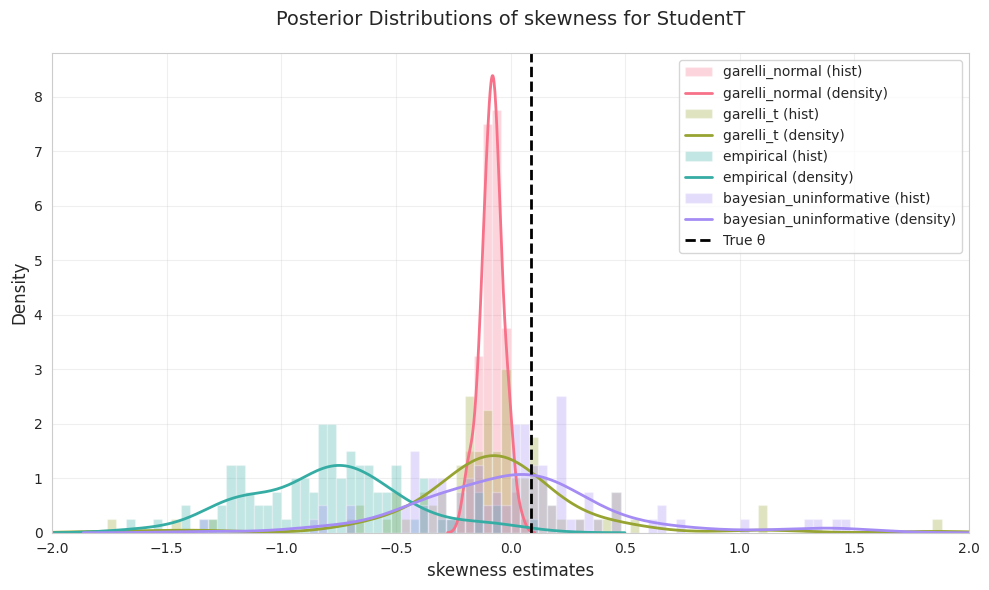

In [84]:
data_dist = 'StudentT'  # Choose from ['Normal', 'SkewNormal', 'StudentT', 'StudentTMixture']
param = 'skewness'  # Choose from ['mean', 'median', 'variance', 'skewness', 'kurtosis']
inference_methods = ['garelli_normal', 'garelli_t', 'empirical', 'bayesian_uninformative']  # ['garelli_normal', 'garelli_t', 'empirical', 'bayesian_uninformative']
param_data_dict = {inference_method: thetas_samples[param] for inference_method, thetas_samples in results.results[data_dist].items() if inference_method in inference_methods}

true_theta = results.results[data_dist]['true'][param]

plot_posterior_distributions(
    param_data_dict,
    true_theta=true_theta,
    plot_type='both',
    bins=100,
    figsize=(10, 6),
    title=f'Posterior Distributions of {param} for {data_dist}',
    xlabel=f'{param} estimates',
    ylabel='Density',
    show_legend=True,
    alpha=0.3,
    x_range=(-2, 2),
)
plt.show()

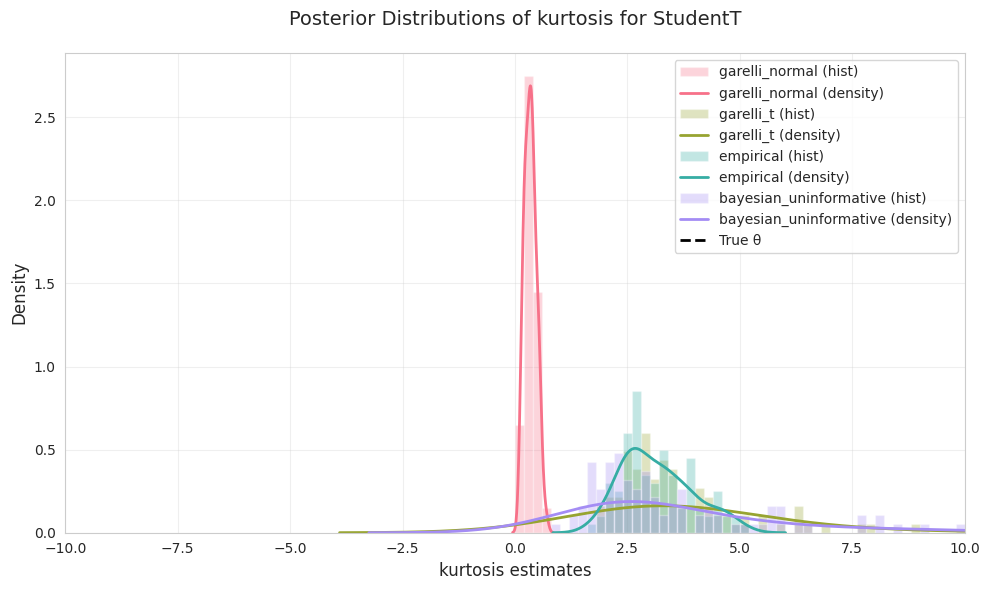

In [85]:
data_dist = 'StudentT'  # Choose from ['Normal', 'SkewNormal', 'StudentT', 'StudentTMixture']
param = 'kurtosis'  # Choose from ['mean', 'median', 'variance', 'skewness', 'kurtosis']
inference_methods = ['garelli_normal', 'garelli_t', 'empirical', 'bayesian_uninformative']  # ['garelli_normal', 'garelli_t', 'empirical', 'bayesian_uninformative']
param_data_dict = {inference_method: thetas_samples[param] for inference_method, thetas_samples in results.results[data_dist].items() if inference_method in inference_methods}

true_theta = results.results[data_dist]['true'][param]

plot_posterior_distributions(
    param_data_dict,
    true_theta=true_theta,
    plot_type='both',
    bins=100,
    figsize=(10, 6),
    title=f'Posterior Distributions of {param} for {data_dist}',
    xlabel=f'{param} estimates',
    ylabel='Density',
    show_legend=True,
    alpha=0.3,
    x_range=(-10, 10),
)
plt.show()

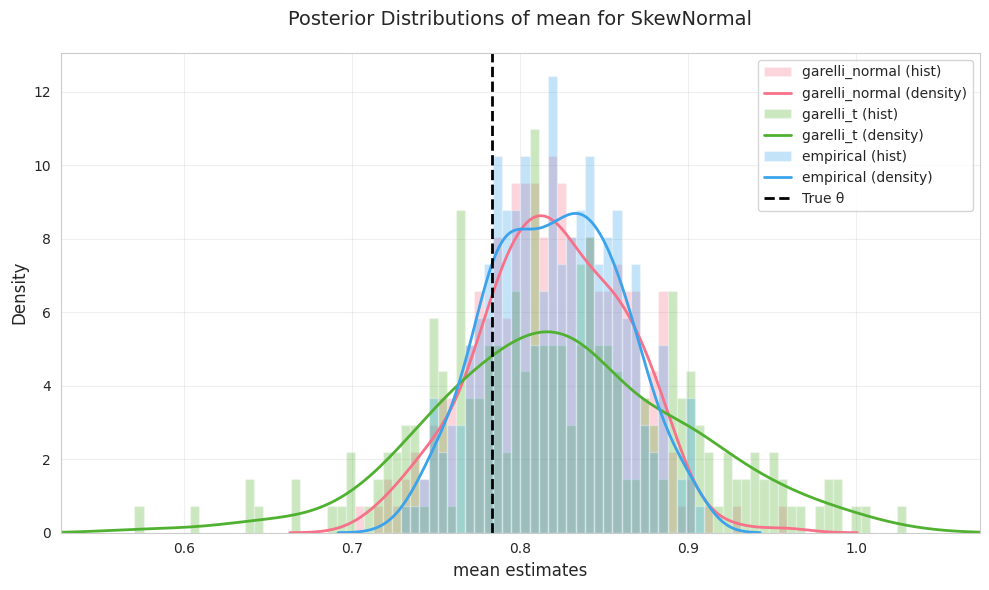

In [33]:
# variance Normal
data_dist = 'SkewNormal'  # Choose from ['Normal', 'SkewNormal', 'StudentT', 'StudentTMixture']
param = 'mean'  # Choose from ['mean', 'median', 'variance', 'skewness', 'kurtosis']
inference_methods = ['garelli_normal', 'garelli_t', 'empirical', 'bayesian_uninformative']  # ['garelli_normal', 'garelli_t', 'empirical', 'bayesian_uninformative']
param_data_dict = {inference_method: thetas_samples[param] for inference_method, thetas_samples in results.results[data_dist].items() if inference_method in inference_methods}

true_theta = results.results[data_dist]['true'][param]

plot_posterior_distributions(
    param_data_dict,
    true_theta=true_theta,
    plot_type='both',
    bins=100,
    figsize=(10, 6),
    title=f'Posterior Distributions of {param} for {data_dist}',
    xlabel=f'{param} estimates',
    ylabel='Density',
    show_legend=True,
    alpha=0.3,
    # x_range=(-1, 1),
)
plt.show()

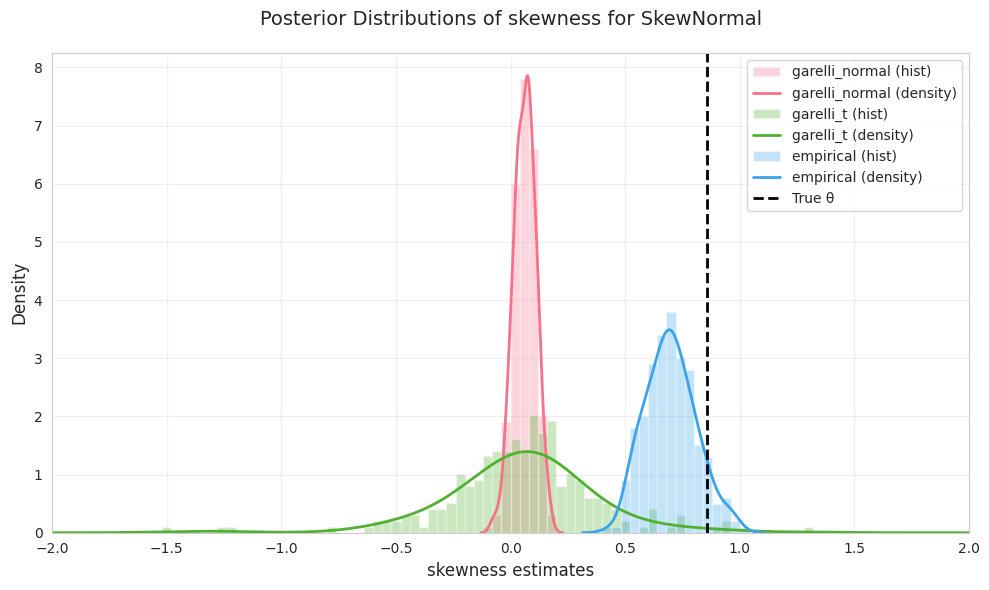

In [58]:
# variance Normal
data_dist = 'SkewNormal'  # Choose from ['Normal', 'SkewNormal', 'StudentT', 'StudentTMixture']
param = 'skewness'  # Choose from ['mean', 'median', 'variance', 'skewness', 'kurtosis']
inference_methods = ['garelli_normal', 'garelli_t', 'empirical', 'bayesian_uninformative']  # ['garelli_normal', 'garelli_t', 'empirical', 'bayesian_uninformative']
param_data_dict = {inference_method: thetas_samples[param] for inference_method, thetas_samples in results.results[data_dist].items() if inference_method in inference_methods}

true_theta = results.results[data_dist]['true'][param]

plot_posterior_distributions(
    param_data_dict,
    true_theta=true_theta,
    plot_type='both',
    bins=100,
    figsize=(10, 6),
    title=f'Posterior Distributions of {param} for {data_dist}',
    xlabel=f'{param} estimates',
    ylabel='Density',
    show_legend=True,
    alpha=0.3,
    x_range=(-2, 2),
)
plt.show()

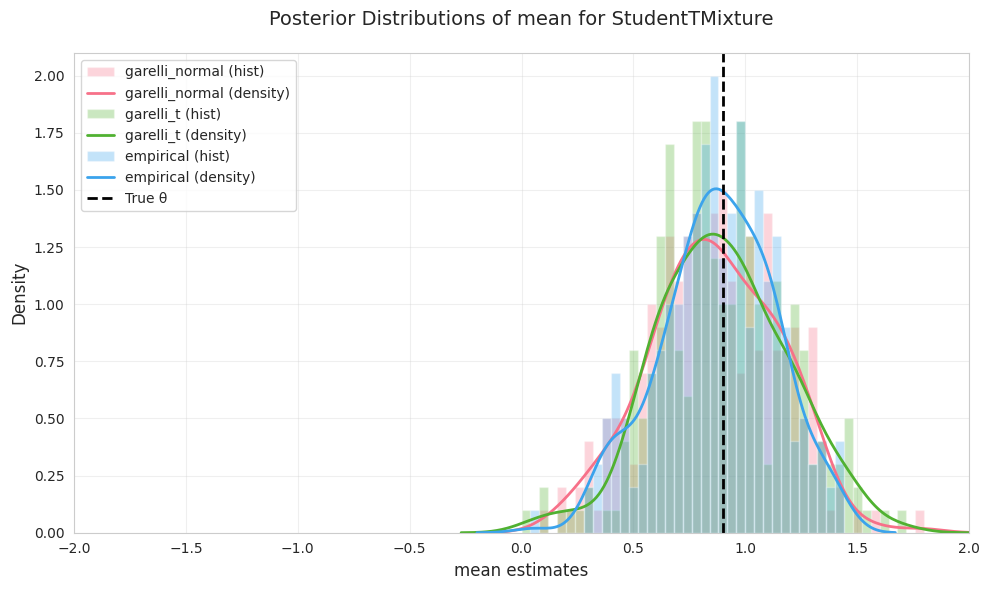

In [59]:
# variance Normal
data_dist = 'StudentTMixture'  # Choose from ['Normal', 'SkewNormal', 'StudentT', 'StudentTMixture']
param = 'mean'  # Choose from ['mean', 'median', 'variance', 'skewness', 'kurtosis']
inference_methods = ['garelli_normal', 'garelli_t', 'empirical', 'bayesian_uninformative']  # ['garelli_normal', 'garelli_t', 'empirical', 'bayesian_uninformative']
param_data_dict = {inference_method: thetas_samples[param] for inference_method, thetas_samples in results.results[data_dist].items() if inference_method in inference_methods}

true_theta = results.results[data_dist]['true'][param]

plot_posterior_distributions(
    param_data_dict,
    true_theta=true_theta,
    plot_type='both',
    bins=100,
    figsize=(10, 6),
    title=f'Posterior Distributions of {param} for {data_dist}',
    xlabel=f'{param} estimates',
    ylabel='Density',
    show_legend=True,
    alpha=0.3,
    x_range=(-2, 2),
)
plt.show()

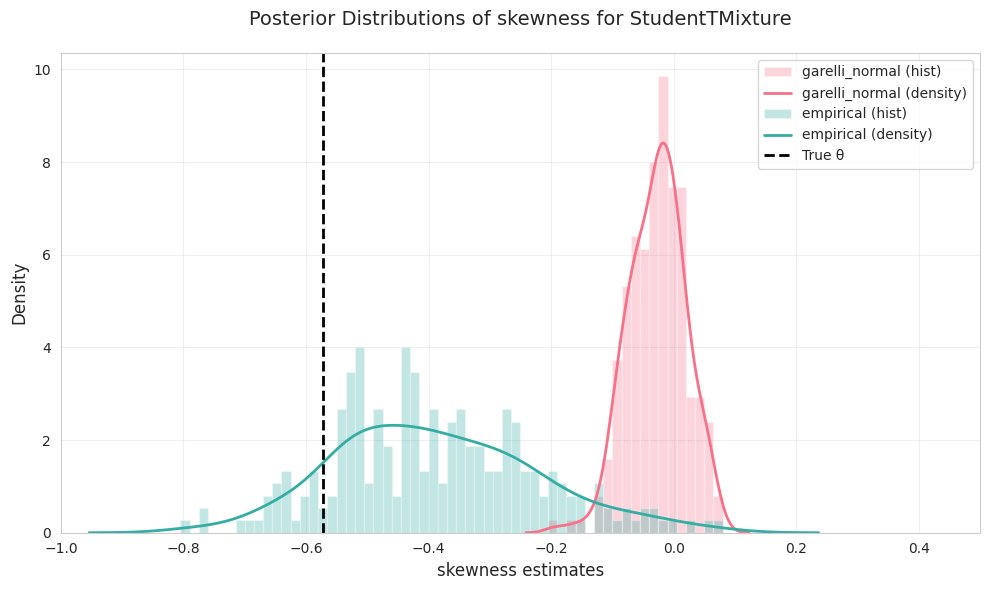

In [73]:
data_dist = 'StudentTMixture'  # Choose from ['Normal', 'SkewNormal', 'StudentT', 'StudentTMixture']
param = 'skewness'  # Choose from ['mean', 'median', 'variance', 'skewness', 'kurtosis']
inference_methods = ['garelli_normal', 'empirical']  # ['garelli_normal', 'garelli_t', 'empirical', 'bayesian_uninformative']
param_data_dict = {inference_method: thetas_samples[param] for inference_method, thetas_samples in results.results[data_dist].items() if inference_method in inference_methods}

true_theta = results.results[data_dist]['true'][param]

plot_posterior_distributions(
    param_data_dict,
    true_theta=true_theta,
    plot_type='both',
    bins=100,
    figsize=(10, 6),
    title=f'Posterior Distributions of {param} for {data_dist}',
    xlabel=f'{param} estimates',
    ylabel='Density',
    show_legend=True,
    alpha=0.3,
    x_range=(-1, 0.5),
)
plt.show()

# Coparison of Bootstrap and ECDF strategy 

In [139]:
#load results from pickle
with open('results_may04_new.pkl', 'rb') as f:
    results_dict = pickle.load(f)

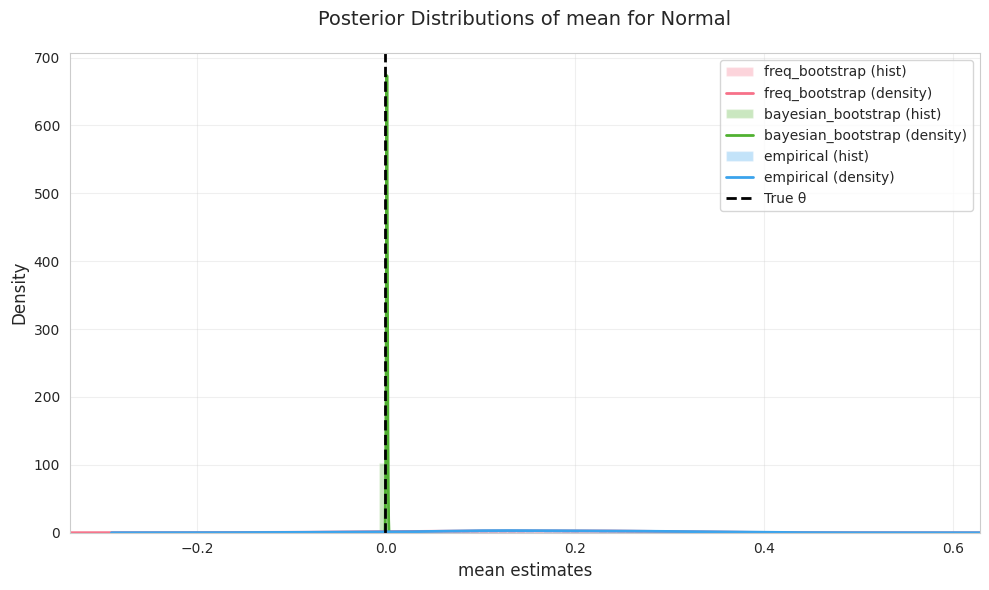

In [142]:
# variance Normal
data_dist = 'Normal'  # Choose from ['Normal', 'SkewNormal', 'StudentT', 'StudentTMixture']
param = 'mean'  # Choose from ['mean', 'median', 'variance', 'skewness', 'kurtosis']
inference_methods = ['freq_bootstrap', 'bayesian_bootstrap', 'empirical']  # ['freq_bootstrap', 'bayesian_bootstrap', 'garelli_normal', 'garelli_t', 'empirical', 'bayesian_uninformative', 'true']
param_data_dict = {inference_method: thetas_samples[param] for inference_method, thetas_samples in results_dict[data_dist].items() if inference_method in inference_methods}

true_theta = results_dict[data_dist]['true'][param]

plot_posterior_distributions(
    param_data_dict,
    true_theta=true_theta,
    plot_type='both',
    bins=100,
    figsize=(10, 6),
    title=f'Posterior Distributions of {param} for {data_dist}',
    xlabel=f'{param} estimates',
    ylabel='Density',
    show_legend=True,
    alpha=0.3,
    # x_range=(3, 5),
)
plt.show()

Empirical std: 10.3395
Theoretical std: 10.3280


Other distributions: dict_keys(['Normal', 'SkewNormal', 'StudentT'])
Other parameters: dict_keys(['mean', 'median', 'variance', 'skewness', 'kurtosis'])


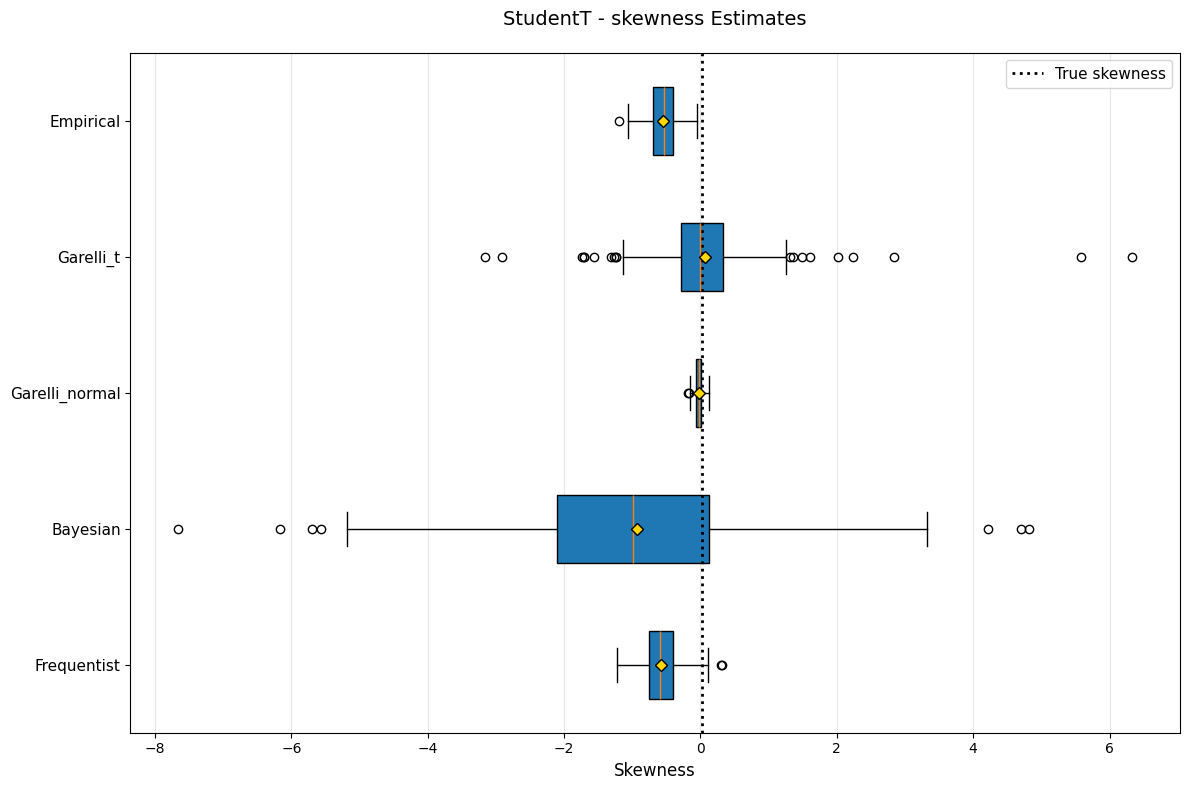

Other distributions: dict_keys(['Normal', 'SkewNormal', 'StudentT'])
Other parameters: dict_keys(['mean', 'median', 'variance', 'skewness', 'kurtosis'])


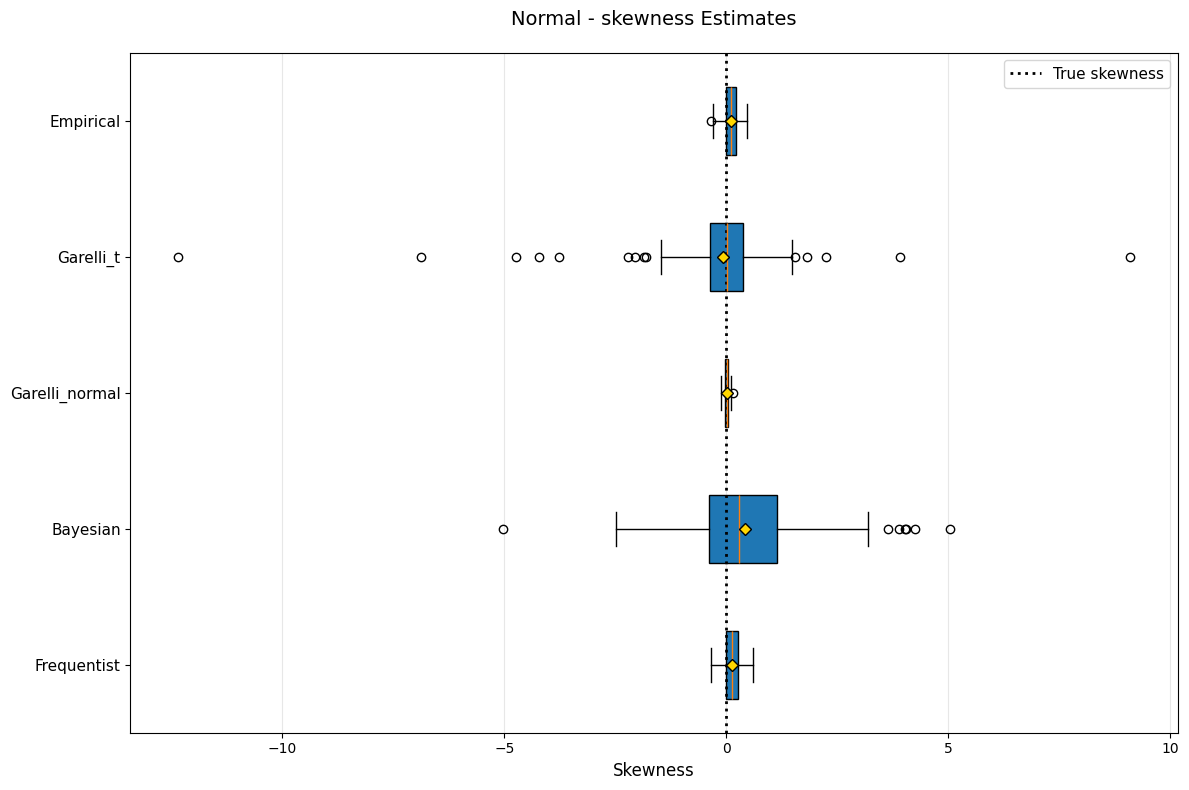

In [45]:
plot_method_boxplots(resultstore=results, dist_name='StudentT', param_name='skewness')
plot_method_boxplots(resultstore=results, dist_name='Normal', param_name='skewness')


Data: Student-t
Sample mean: -0.00, skewness: 0.11
Frequentist Bootstrap mean: 0.14, skewness: 1.71


Bayes Boot: 100%|██████████| 100/100 [00:00<00:00, 7529.09it/s]


Bayesian Bootstrap mean: 0.13, skewness: 1.89


Garelli: 100%|██████████| 100/100 [00:11<00:00,  8.74it/s]


Garelli Predictive mean: 0.14, skewness: 0.66


Empirical Pred: 100%|██████████| 100/100 [00:25<00:00,  3.90it/s]


Empirical Predictive mean: 0.13, skewness: 1.30


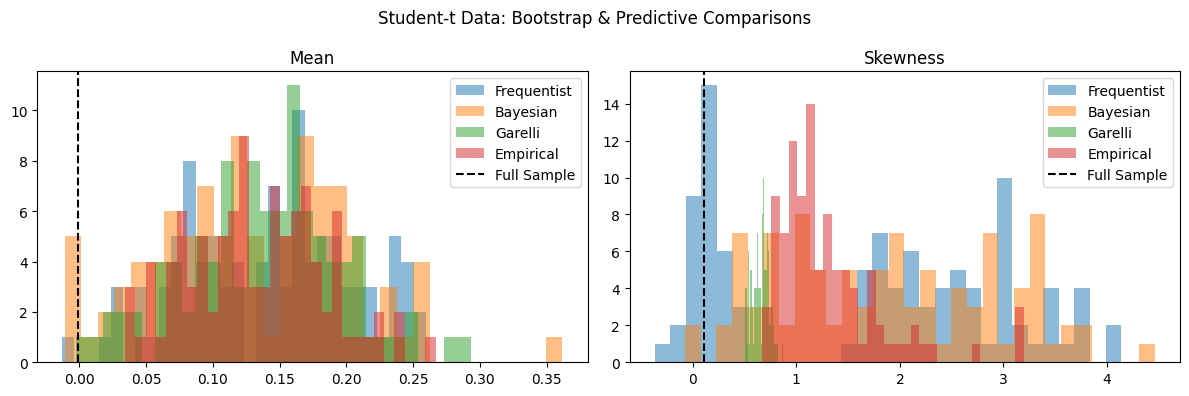

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm import tqdm

# Settings
# np.random.seed(421)
n_obs = 500
B = 100
n_resample = 1000  # Number of "future" predictive samples

n_tot = 100*(n_obs + n_resample)  # Total number of samples to estimate real value of theta

# 1. Simulate Data
mu, sigma = 0, 1
alpha = 5

X_normal = stats.skewnorm.rvs(loc=0, scale=1, a=alpha, size=n_tot)#np.random.normal(mu, sigma, n_tot)
df = 4
X_t = np.random.standard_t(df, size=n_tot)

def get_theta(x):
    mean = np.mean(x)
    skew = stats.skew(x, bias=False)
    return mean, skew

# Frequentist Bootstrap
def freq_bootstrap(X, B):
    n = len(X)
    thetas = []
    for _ in range(B):
        x_sample = np.random.choice(X, size=n, replace=True)
        thetas.append(get_theta(x_sample))
    return np.array(thetas)

# Bayesian Bootstrap
def bayes_bootstrap(X, B):
    n = len(X)
    thetas = []
    for _ in tqdm(range(B), desc="Bayes Boot"):
        weights = np.diff(np.concatenate(([0], np.sort(np.random.uniform(0,1, n-1)), [1])))
        mean = np.sum(weights * X)
        std = np.sqrt(np.sum(weights * (X-mean)**2))
        skew = np.sum(weights * ((X-mean)/std)**3)
        thetas.append([mean, skew])
    return np.array(thetas)

# Predictive Resampling with Garelli Priors
def garelli_normal_predictive_resampling(X, B, n_resample):
    n = len(X)
    thetas = []
    for b in tqdm(range(B), desc="Garelli"):
        X_aug = list(X)
        for j in range(n_resample):
            x_prev = np.array(X_aug)
            if len(x_prev) < 2:
                pred_mean = np.mean(x_prev)
                pred_std = np.std(x_prev, ddof=1) if len(x_prev)>1 else 1.0
            else:
                pred_mean = np.mean(x_prev)
                pred_std = np.std(x_prev, ddof=1)
            pred_sample = np.random.normal(pred_mean, pred_std)
            X_aug.append(pred_sample)
        thetas.append(get_theta(np.array(X_aug)))
    return np.array(thetas)

# Predictive Resampling (empirical, cdf is supposed continuous due to the def of ecdf_inv)
from src.utils import ecdf_inv
def empirical_predictive_resampling(X, B, n_resample):
    thetas = []
    for b in tqdm(range(B), desc="Empirical Pred"):
        X_aug = list(X)
        for j in range(n_resample):
            x_prev = np.array(X_aug)
            u = np.random.uniform(0, 1)
            pred_sample = ecdf_inv(x_prev, u)
            X_aug.append(pred_sample)
        thetas.append(get_theta(np.array(X_aug)))
    return np.array(thetas)

# Storage for inferences
inferences_normal = {}
inferences_t = {}

# Main Loop
for data_name, X, X_all, inference_store in [
    # ('Normal', X_normal[:n_obs], X_normal, inferences_normal),
    ('Student-t', X_t[:n_obs], X_t, inferences_t)
]:
    print(f"\nData: {data_name}")
    
    m, s = get_theta(X_all)
    print(f"Sample mean: {m:.2f}, skewness: {s:.2f}")
    
    freq_thetas = freq_bootstrap(X, B)
    print(f"Frequentist Bootstrap mean: {freq_thetas[:,0].mean():.2f}, skewness: {freq_thetas[:,1].mean():.2f}")
    inference_store['freq'] = freq_thetas

    bayes_thetas = bayes_bootstrap(X, B)
    print(f"Bayesian Bootstrap mean: {bayes_thetas[:,0].mean():.2f}, skewness: {bayes_thetas[:,1].mean():.2f}")
    inference_store['bayes'] = bayes_thetas

    garelli_thetas = garelli_normal_predictive_resampling(X, B, n_resample)
    print(f"Garelli Predictive mean: {garelli_thetas[:,0].mean():.2f}, skewness: {garelli_thetas[:,1].mean():.2f}")
    inference_store['garelli'] = garelli_thetas

    emp_pred_thetas = empirical_predictive_resampling(X, B, n_resample)
    print(f"Empirical Predictive mean: {emp_pred_thetas[:,0].mean():.2f}, skewness: {emp_pred_thetas[:,1].mean():.2f}")
    inference_store['empirical'] = emp_pred_thetas

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].hist(freq_thetas[:,0], bins=30, alpha=0.5, label='Frequentist')
    axs[0].hist(bayes_thetas[:,0], bins=30, alpha=0.5, label='Bayesian')
    axs[0].hist(garelli_thetas[:,0], bins=30, alpha=0.5, label='Garelli')
    axs[0].hist(emp_pred_thetas[:,0], bins=30, alpha=0.5, label='Empirical')
    axs[0].axvline(m, color='k', linestyle='--', label='Full Sample')
    axs[0].set_title('Mean')
    axs[0].legend()
    
    axs[1].hist(freq_thetas[:,1], bins=30, alpha=0.5, label='Frequentist')
    axs[1].hist(bayes_thetas[:,1], bins=30, alpha=0.5, label='Bayesian')
    axs[1].hist(garelli_thetas[:,1], bins=30, alpha=0.5, label='Garelli')
    axs[1].hist(emp_pred_thetas[:,1], bins=30, alpha=0.5, label='Empirical')
    axs[1].axvline(s, color='k', linestyle='--', label='Full Sample')
    axs[1].set_title('Skewness')
    axs[1].legend()
    plt.suptitle(f'{data_name} Data: Bootstrap & Predictive Comparisons')
    plt.tight_layout()
    plt.show()

## Comparing with various $n_{obs}$ and $n_{res}$


In [ ]:
def get_theta(x):
    mean = np.mean(x)
    skew = stats.skew(x, bias=True)
    return mean, skew

def freq_bootstrap(X, B, n_resample=None):
    n = len(X)
    thetas = []
    for _ in tqdm(range(B)):
        x_sample = np.random.choice(X, size=n, replace=True)
        thetas.append(get_theta(x_sample))
    return np.array(thetas)

def bayes_bootstrap(X, B, n_resample=None):
    n = len(X)
    thetas = []
    for _ in tqdm(range(B)):
        weights = np.diff(np.concatenate(([0], np.sort(np.random.uniform(0,1, n-1)), [1])))
        mean = np.sum(weights * X)
        std = np.sqrt(np.sum(weights * (X-mean)**2))
        # Avoid division by zero for std
        if std == 0:
            skew = 0.0
        else:
            skew = np.sum(weights * ((X-mean)/std)**3)
        thetas.append([mean, skew])
    return np.array(thetas)

def garelli_normal_predictive_resampling(X, B, n_resample):
    thetas = []
    for b in tqdm(range(B)):
        X_aug = list(X)
        for j in range(n_resample):
            x_prev = np.array(X_aug)
            if len(x_prev) < 2:
                pred_mean = np.mean(x_prev)
                pred_std = np.std(x_prev, ddof=1) if len(x_prev)>1 else 1.0
            else:
                pred_mean = np.mean(x_prev)
                pred_std = np.std(x_prev, ddof=1)
            pred_sample = np.random.normal(pred_mean, pred_std)
            X_aug.append(pred_sample)
        thetas.append(get_theta(np.array(X_aug)))
    return np.array(thetas)


def bayesian_inference_old(X, B, prior_type='uninformative', n_resample=None):
    """
    Bayesian inference with normal likelihood and different priors
    
    Args:
        X: Observed data
        B: Number of posterior samples
        prior_type: 'uninformative' (Jeffreys prior) or 
                   'informative' (Normal-Inverse-Gamma prior)
    
    Returns:
        Array of posterior samples for theta = (mean, skewness)
    """
    n = len(X)
    x_bar = np.mean(X)
    s2 = np.var(X, ddof=1)  # Sample variance
    thetas = []
    
    if prior_type == 'uninformative':
        # Jeffreys prior (non-informative)
        a_sigma = (n - 1) / 2
        scale_sigma = (n - 1) * s2 / 2
        
        for _ in tqdm(range(B), desc=f"Bayesian Inf ({prior_type})"):
            # Sample from posterior
            sigma2 = stats.invgamma.rvs(a=a_sigma, scale=scale_sigma)
            mu = np.random.normal(x_bar, np.sqrt(sigma2/n))
            
            # Generate predictive sample
            sample = np.random.normal(mu, np.sqrt(sigma2), n)
            thetas.append(get_theta(sample))
            
    elif prior_type == 'informative':
        # Example informative prior parameters (customize these!)
        mu0 = 0.0    # Prior mean
        k0 = 10.0    # Prior pseudo-observations
        a0 = 5.0     # Prior shape for variance
        b0 = 2.0     # Prior scale for variance
        
        # Update parameters
        mu_n = (k0*mu0 + n*x_bar) / (k0 + n)
        k_n = k0 + n
        a_n = a0 + n/2
        b_n = b0 + 0.5*(n*s2 + (k0*n*(x_bar - mu0)**2)/(k0 + n))
        
        for _ in tqdm(range(B), desc=f"Bayesian Inf ({prior_type})"):
            # Sample from posterior
            sigma2 = stats.invgamma.rvs(a=a_n, scale=b_n)
            mu = np.random.normal(mu_n, np.sqrt(sigma2/k_n))
            
            # Generate predictive sample
            sample = np.random.normal(mu, np.sqrt(sigma2), n)
            thetas.append(get_theta(sample))
            
    else:
        raise ValueError("prior_type must be 'uninformative' or 'informative'")
    
    return np.array(thetas)

In [ ]:
import numpy as np
import scipy.stats as stats
from tqdm import tqdm
from functools import partial


# np.random.seed(421)
mu, sigma = 0, 1
alpha = 5
df = 4

n_obs_grid = [100, 1000]
n_resample_grid = [1000, 5000]
methods_dict = {
    # 'Frequentist Bootstrap': freq_bootstrap,
    'Bayesian Bootstrap': bayes_bootstrap,
    'Predictive Garelli': garelli_normal_predictive_resampling,
    'Predictive Empirical': empirical_predictive_resampling,
    'Bayesian Uninformative': partial(bayesian_inference, prior_type='uninformative'),
    # 'Bayesian Informative': partial(bayesian_inference, prior_type='informative'),
}
B = 250
n_tot = 10 * max(n_obs_grid) * 4  # Large enough pop sample

# Simulate population data
X_normal_pop = np.random.normal(mu, sigma, n_tot)
X_t_pop = np.random.standard_t(df, size=n_tot)
X_skew_pop = stats.skewnorm.rvs(a=alpha, loc=0, scale=1, size=n_tot)



##########################
# Collect Results
all_results = {}

for dist_name, X_pop in [('Normal', X_normal_pop), ('Student-t', X_t_pop)]:
    all_results[dist_name] = {}
    real_mean, real_skew = get_theta(X_pop)
    for n_obs in n_obs_grid:
        for n_resample in [n_res for n_res in n_resample_grid if n_res > n_obs]:
            key = (n_obs, n_resample)
            print(f"Processing {dist_name}: n_obs={n_obs}, n_resample={n_resample}")

            # Observed sample for this run
            X_obs = X_pop[:n_obs]

            # Run all inference methods
            res = {}
            for method_name, method_func in methods_dict.items():
                res[method_name] = method_func(X_obs, B, n_resample=n_resample)
        
            
            all_results[dist_name][key] = res

    all_results[dist_name]['real'] = (real_mean, real_skew)

Processing Normal: n_obs=100, n_resample=1000


Bayesian Inf (uninformative): 100%|██████████| 250/250 [00:00<00:00, 1525.90it/s]


Processing Normal: n_obs=100, n_resample=5000


Bayesian Inf (uninformative): 100%|██████████| 250/250 [00:00<00:00, 1319.16it/s]


Processing Normal: n_obs=1000, n_resample=5000


Bayesian Inf (uninformative): 100%|██████████| 250/250 [00:00<00:00, 949.36it/s]


Processing Student-t: n_obs=100, n_resample=1000


Bayesian Inf (uninformative): 100%|██████████| 250/250 [00:00<00:00, 1595.69it/s]


Processing Student-t: n_obs=100, n_resample=5000


Bayesian Inf (uninformative): 100%|██████████| 250/250 [00:00<00:00, 1346.08it/s]


Processing Student-t: n_obs=1000, n_resample=5000


Bayesian Inf (uninformative): 100%|██████████| 250/250 [00:00<00:00, 1082.41it/s]


In [18]:
# save all_results to a file
import pickle
with open('all_results_may2.pkl', 'wb') as f:
    pickle.dump(all_results, f)

In [56]:
import matplotlib.pyplot as plt

def summarize_and_plot(all_results, dist_name, param_idx=0, param_name='mean'):
    real_theta = all_results[dist_name]['real'][param_idx]
    plt.figure(figsize=(10, 7))
    pos = 0
    yticks = []
    ys = []

    for i, n_obs in enumerate(n_obs_grid):
        for j, n_resample in enumerate([n_res for n_res in n_resample_grid if n_res > n_obs]):
            key = (n_obs, n_resample)
            base_ypos = pos
            group_ys = []
            for k, meth in enumerate(methods_dict.keys()):
                thetas = all_results[dist_name][key][meth][:,param_idx]
                mean = np.mean(thetas)
                q1 = np.percentile(thetas, 25)
                q4 = np.percentile(thetas, 75)
                cilo, cihi = np.percentile(thetas, [2.5, 97.5])
                ypos = base_ypos + k*0.08
                group_ys.append(ypos)
                plt.plot([cilo, cihi], [ypos, ypos], color='b', lw=4, alpha=0.8)
                plt.plot([q1, q4], [ypos, ypos], color='orange', lw=8, alpha=0.6)
                plt.plot([mean], [ypos], 'ko', markersize=7)
                plt.text(cihi, ypos, f" {meth}", va='center', fontsize=7)
            # Label once for the whole group, centered
            group_center = np.mean(group_ys)
            ys.append(group_center)
            yticks.append(f"n_obs={n_obs}\nn_res={n_resample}")
            pos += 1.0

    plt.axvline(real_theta, color='r', linestyle='--', lw=2, label='True (population)')
    plt.yticks(ys, yticks)
    plt.xlabel(param_name, fontsize=13)
    plt.ylabel('')
    plt.title(f"{dist_name}: Inference for {param_name}\n(CI in blue, IQR in orange, mean as dot)", fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()

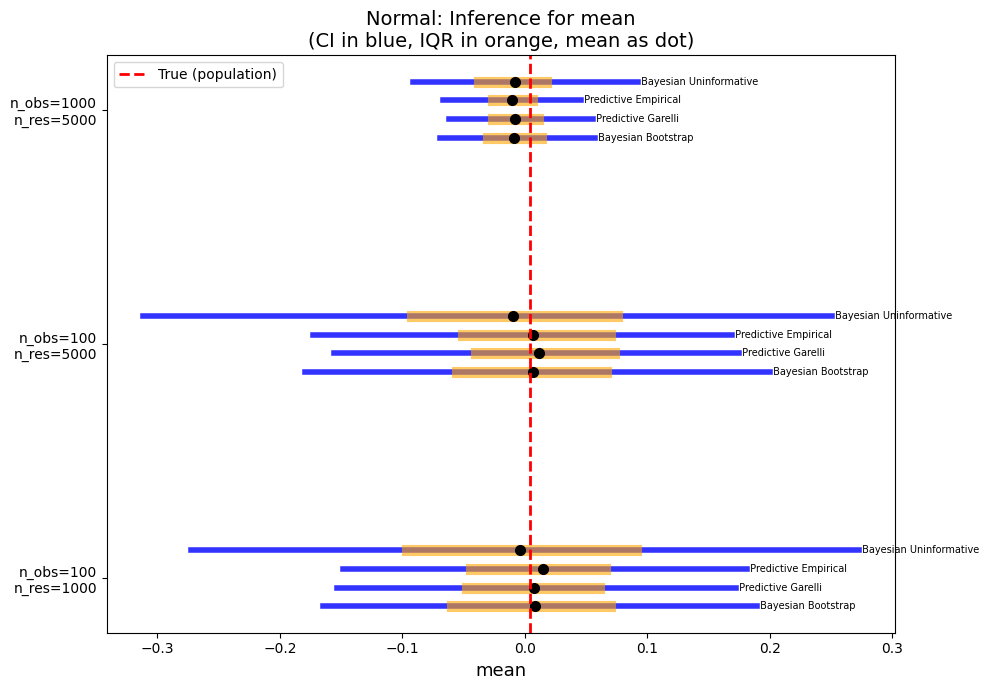

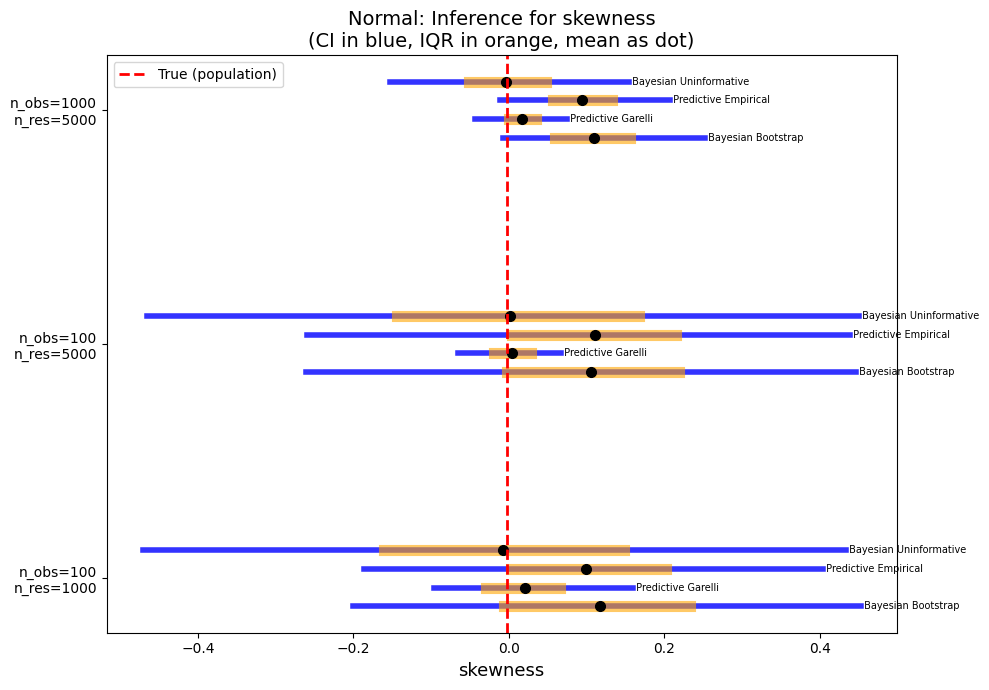

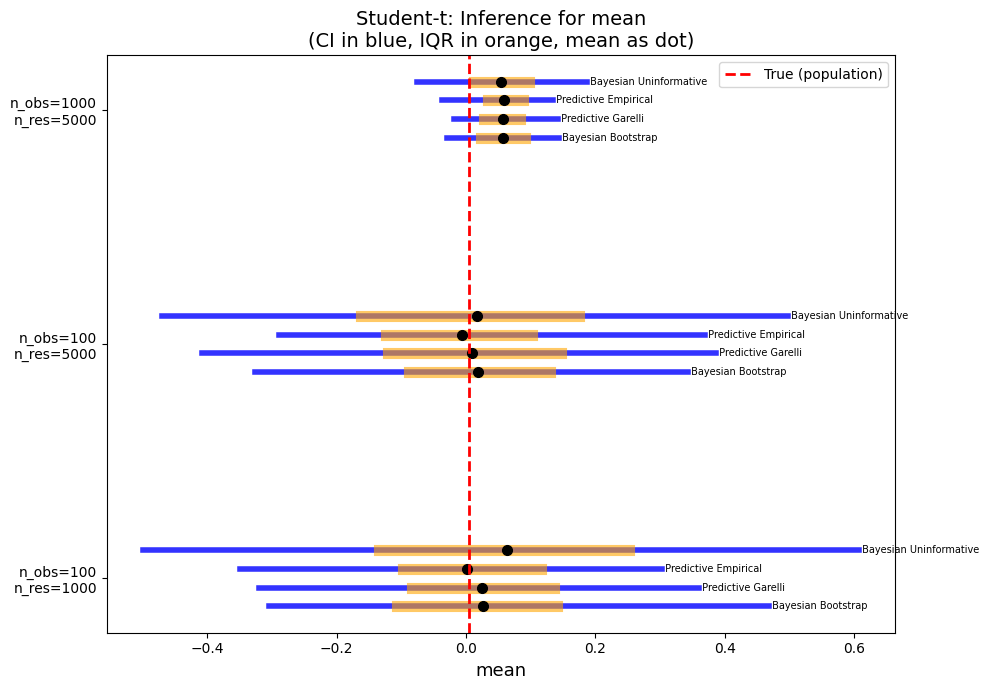

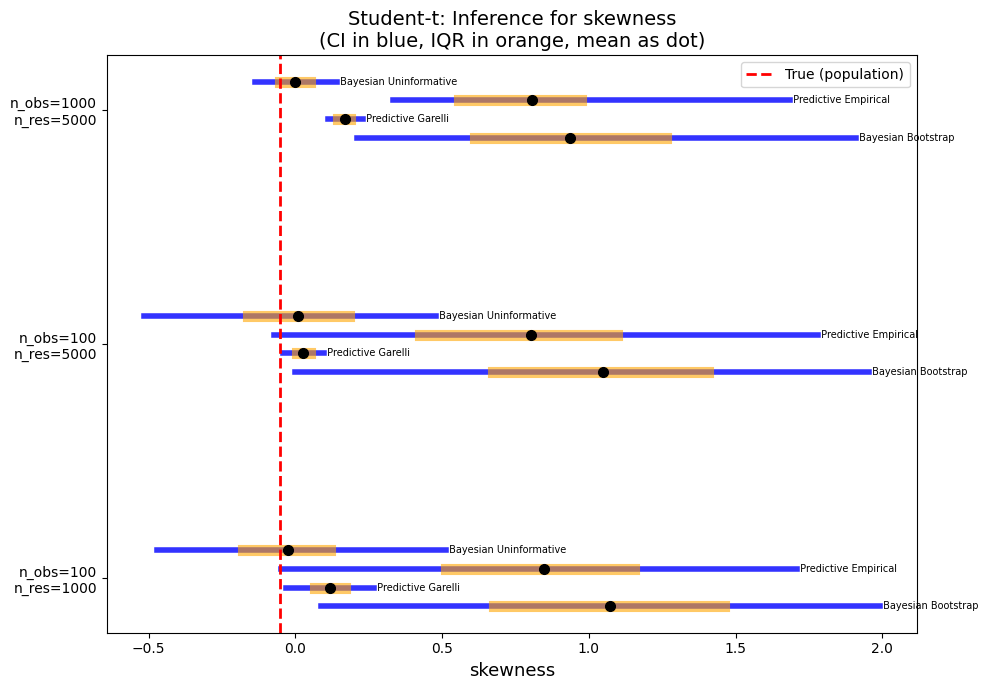

In [22]:
summarize_and_plot(all_results, "Normal", param_idx=0, param_name="mean")
summarize_and_plot(all_results, "Normal", param_idx=1, param_name="skewness")
summarize_and_plot(all_results, "Student-t", param_idx=0, param_name="mean")
summarize_and_plot(all_results, "Student-t", param_idx=1, param_name="skewness")